In [12]:
from hllhc_rematch_tools import *
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
optics_name = "opt/opt_collapse_1100_1500.madx"

collider = None
collider_name = "collider_hl16.json"
if os.path.exists(collider_name):
    collider = xt.Multiline.from_json(collider_name)
else:
    collider = build_collider(optics_name, cycling=False)
    collider.to_json(collider_name)

collider.vars.load_madx_optics_file(optics_name)

Loading line from dict: 100%|██████████| 30815/30815 [00:00<00:00, 32822.87it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 30855/30855 [00:00<00:00, 30970.17it/s]


Done loading line from dict.           


In [14]:
tw = collider.twiss()

print(tw["lhcb1"][["betx", "bety"], "ip.*"])
print(tw["lhcb2"][["betx", "bety"], "ip.*"])

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
TwissTable: 9 rows, 3 cols
name                        betx    bety
ip1                          1.1     1.1
ip2                           10      10
ip3                      121.567 218.585
ip4                       236.18 306.197
ip5                          1.1     1.1
ip6                      207.871 162.292
ip7                      120.813 149.431
ip8                          1.5     1.5
ip1.l1                       1.1     1.1
TwissTable: 9 rows, 3 cols
name                        betx    bety
ip1                          1.1     1.1
ip2                           10      10
ip3                      121.567 218.584
ip4                      236.148 320.924
ip5                          1.1     1.1
ip6                      193.605 164.973
ip7                  

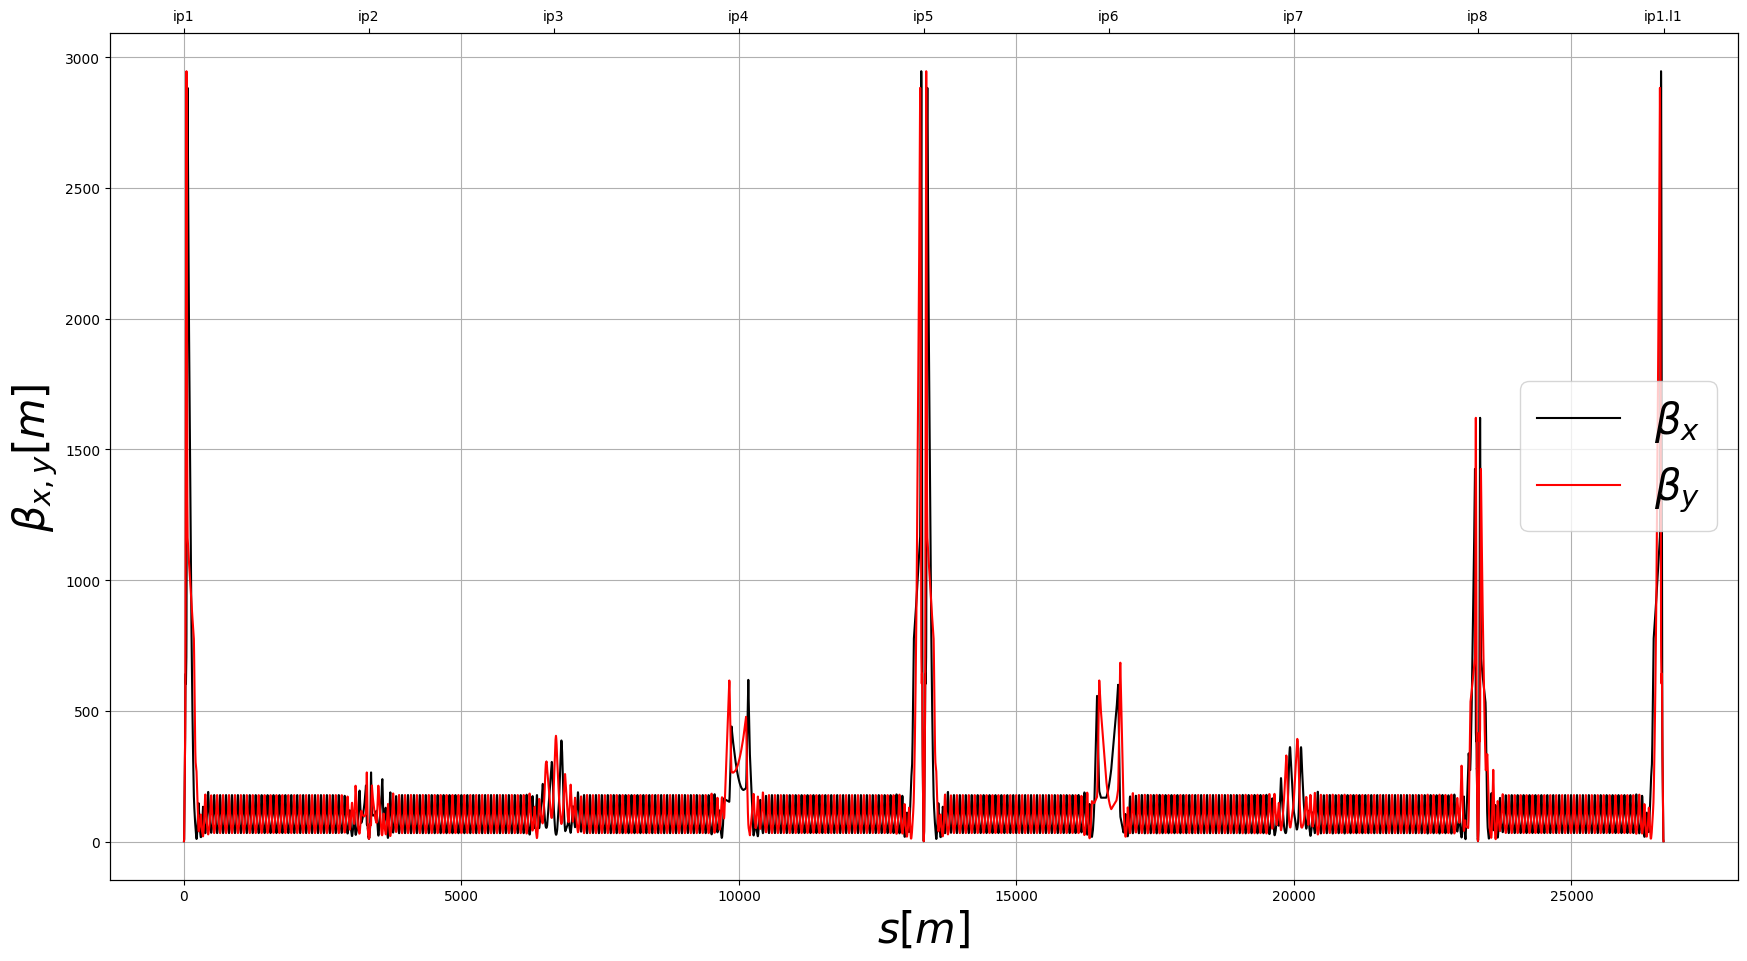

In [15]:
fig, axs = plt.subplots(figsize=(21, 11))
axs.plot(tw["lhcb1"].s, tw["lhcb1"].betx, label=r"$\beta_x$", color="black")
axs.plot(tw["lhcb1"].s, tw["lhcb1"].bety, label=r"$\beta_y$", color="red")
axs_t = axs.twiny()
axs_t.set_xticks(
    tw["lhcb1"][["s"], "ip.*"],
    tw["lhcb1"][["name"], "ip.*"],
    rotation="horizontal",
)
axs_t.set_xlim(axs.get_xlim()[0], axs.get_xlim()[1])
axs.set_ylabel(r"$\beta_{x,y} [m]$", fontsize=30)
axs.set_xlabel(r"$s [m]$", fontsize=30)
axs.legend(fontsize=30)
axs.grid()
plt.show()

In [16]:
staged_match = True

In [17]:
betx0_ip1 = 1.1
bety0_ip1 = 1.1
betx0_ip5 = 1.1
bety0_ip5 = 1.1

betx_ip1 = betx0_ip1
bety_ip1 = bety0_ip1
betx_ip5 = betx0_ip5
bety_ip5 = bety0_ip5

In [18]:
lm.set_var_limits_and_steps(collider)

In [19]:
muxs = {}
muys = {}

saved_vars = {}
saved_vars.update(
    {
        "b1": {"ip2": {}, "ip3": {}, "ip4": {}, "ip6": {}, "ip7": {}, "ip8": {}},
        "b2": {"ip2": {}, "ip3": {}, "ip4": {}, "ip6": {}, "ip7": {}, "ip8": {}},
    }
)

for bim in ["b1", "b2"]:
    for arc_name in lm.ARC_NAMES:
        muxs[f"mux{arc_name}{bim}"] = collider.varval[f"mux{arc_name}{bim}"]
        muys[f"muy{arc_name}{bim}"] = collider.varval[f"muy{arc_name}{bim}"]
    for ip_name in [2, 4, 6, 8]:
        muxs[f"muxip{ip_name}{bim}"] = collider.varval[f"muxip{ip_name}{bim}"]
        muys[f"muyip{ip_name}{bim}"] = collider.varval[f"muyip{ip_name}{bim}"]
    for ip_name in [1, 5]:
        muxs[f"muxip{ip_name}{bim}_l"] = collider.varval[f"muxip{ip_name}{bim}_l"]
        muys[f"muyip{ip_name}{bim}_l"] = collider.varval[f"muyip{ip_name}{bim}_l"]
        muxs[f"muxip{ip_name}{bim}_r"] = collider.varval[f"muxip{ip_name}{bim}_r"]
        muys[f"muyip{ip_name}{bim}_r"] = collider.varval[f"muyip{ip_name}{bim}_r"]

    saved_vars[bim]["ip2"]["betx"] = collider.varval[f"betxip2{bim}"]
    saved_vars[bim]["ip2"]["bety"] = collider.varval[f"betyip2{bim}"]

    for ip_name in [3, 7]:
        for param in ["betx", "bety", "alfx", "alfy", "dx", "dpx", "mux", "muy"]:
            saved_vars[bim][f"ip{ip_name}"][param] = collider.varval[
                f"{param}ip{ip_name}{bim}"
            ]

    for ip_name in [4, 6, 8]:
        for param in ["betx", "bety", "alfx", "alfy", "dx", "dpx"]:
            saved_vars[bim][f"ip{ip_name}"][param] = collider.varval[
                f"{param}ip{ip_name}{bim}"
            ]


In [20]:
tw45_56_xt = lm.get_arc_periodic_solution(collider, arc_name=["45", "56"])
tw81_12_xt = lm.get_arc_periodic_solution(collider, arc_name=["81", "12"])


Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.
Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.


Presquezze twiss

In [21]:
beta0 = tw45_56_xt["lhcb1"]["45"].get_twiss_init("s.ds.l5.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip5 = collider.lhcb1.twiss(
    start="s.ds.l5.b1", end="e.ds.r5.b1", init=beta0
)
beta0 = tw81_12_xt["lhcb1"]["81"].get_twiss_init("s.ds.l1.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip1 = collider.lhcb1.cycle("ip3").twiss(
    start="s.ds.l1.b1", end="e.ds.r1.b1", init=beta0, method="4d"
)

In [22]:
print(tw_ip1[["betx", "bety"], "ip.*"])
print(tw_ip5[["betx", "bety"], "ip.*"])

TwissTable: 2 rows, 3 cols
name                   betx bety
ip1.l1                  1.1  1.1
ip1                     1.1  1.1
TwissTable: 1 row, 3 cols
name                   betx bety
ip5                     1.1  1.1


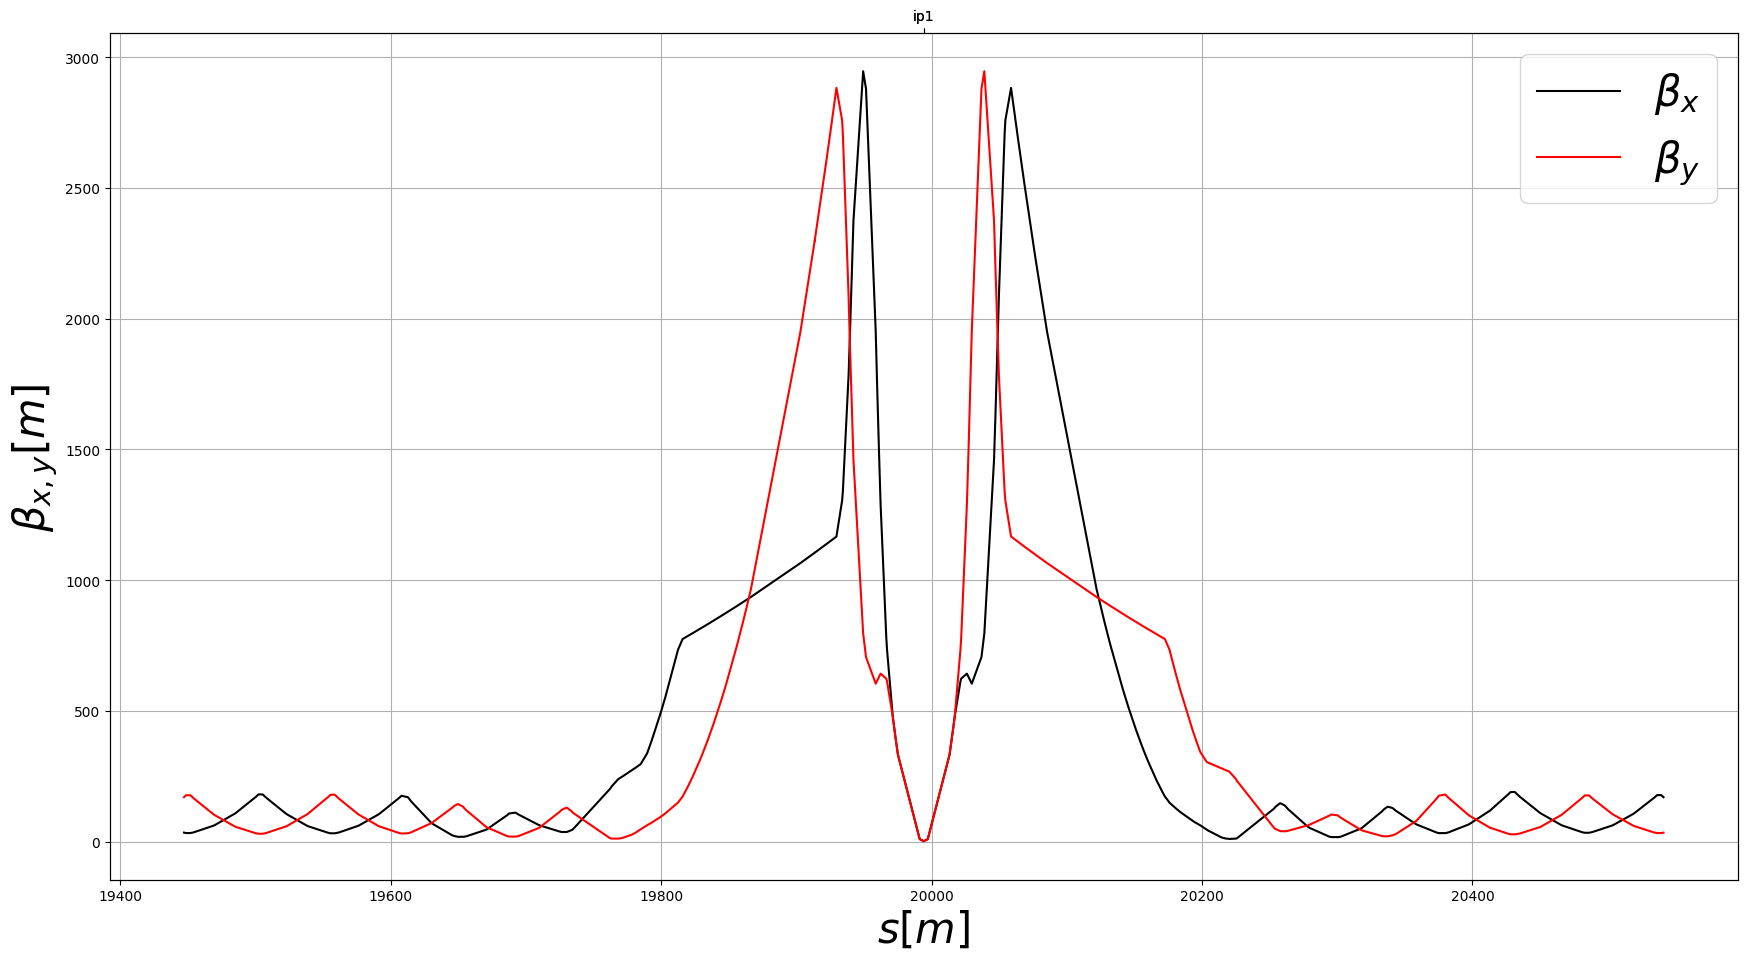

In [23]:
fig, axs = plt.subplots(figsize=(21, 11))
axs.plot(tw_ip1.s, tw_ip1.betx, label=r"$\beta_x$", color="black")
axs.plot(tw_ip1.s, tw_ip1.bety, label=r"$\beta_y$", color="red")
axs_t = axs.twiny()
axs_t.set_xticks(
    tw_ip1[["s"], "ip.*"],
    tw_ip1[["name"], "ip.*"],
    rotation="horizontal",
)
axs_t.set_xlim(axs.get_xlim()[0], axs.get_xlim()[1])
axs.set_ylabel(r"$\beta_{x,y} [m]$", fontsize=30)
axs.set_xlabel(r"$s [m]$", fontsize=30)
axs.legend(fontsize=30)
axs.grid()
plt.show()

In [24]:
optimizers = {}

In [26]:
set_var_limits_and_steps(collider)
set_var_limits_and_steps_orbit_ip15(collider)
set_var_limits_and_steps_sextupoles_w(collider)
set_var_limits_and_steps_ksf_ksd(collider)
set_var_limits_and_steps_disp_correctors(collider)
set_var_limits_and_steps_ahvcrab(collider)

In [31]:
optimizers["ir15"] = rematch_ir15(
    collider,
    betx0_ip5,
    bety0_ip5,
    tw_sq_a45_ip5_a56=tw45_56_xt,
    restore=False,
    ir5q4sym=0,
    ir5q5sym=0,
    ir5q6sym=0,
    solve=True,
    match_on_triplet=0,
)

Matching: model call n. 42       



In [32]:
print(optimizers["ir15"].target_status())
print(optimizers["ir15"].log())

Target status:                   
id state tag tol_met      residue  current_val target_val description                                 
 0 ON           True -7.77156e-15          1.1        1.1 line=lhcb1, ('betx', 'ip5'), val=1.1, to ...
 1 ON           True  2.44249e-15          1.1        1.1 line=lhcb1, ('bety', 'ip5'), val=1.1, to ...
 2 ON           True -7.72593e-15 -7.72593e-15          0 line=lhcb1, ('alfx', 'ip5'), val=0, tol= ...
 3 ON           True  2.49171e-14  2.49171e-14          0 line=lhcb1, ('alfy', 'ip5'), val=0, tol= ...
 4 ON           True -1.71512e-16 -1.71512e-16          0 line=lhcb1, ('dx', 'ip5'), val=0, tol=1e ...
 5 ON           True -1.20947e-16 -1.20947e-16          0 line=lhcb1, ('dpx', 'ip5'), val=0, tol=1 ...
 6 ON           True -8.88178e-16          1.1        1.1 line=lhcb2, ('betx', 'ip5'), val=1.1, to ...
 7 ON           True -2.13163e-14          1.1        1.1 line=lhcb2, ('bety', 'ip5'), val=1.1, to ...
 8 ON           True  -1.3732e-14  -1.3

In [33]:
tw81_45_new = lm.get_arc_periodic_solution(collider, arc_name=["81", "45"])

beta0 = tw81_45_new["lhcb1"]["45"].get_twiss_init("s.ds.l5.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip5_new = collider.lhcb1.twiss(
    start="s.ds.l5.b1", end="e.ds.r5.b1", init=beta0
)


beta0 = tw81_45_new["lhcb1"]["81"].get_twiss_init("s.ds.l1.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip1_new = collider.lhcb1.cycle("ip3").twiss(
    start="s.ds.l1.b1", end="e.ds.r1.b1", init=beta0
)


In [34]:
print(tw_ip5_new[["betx", "bety"], "ip5"])
print(tw_ip1_new[["betx", "bety"], "ip1"])

TwissTable: 1 row, 3 cols
name                   betx bety
ip5                     1.1  1.1
TwissTable: 1 row, 3 cols
name                   betx bety
ip1                     1.1  1.1


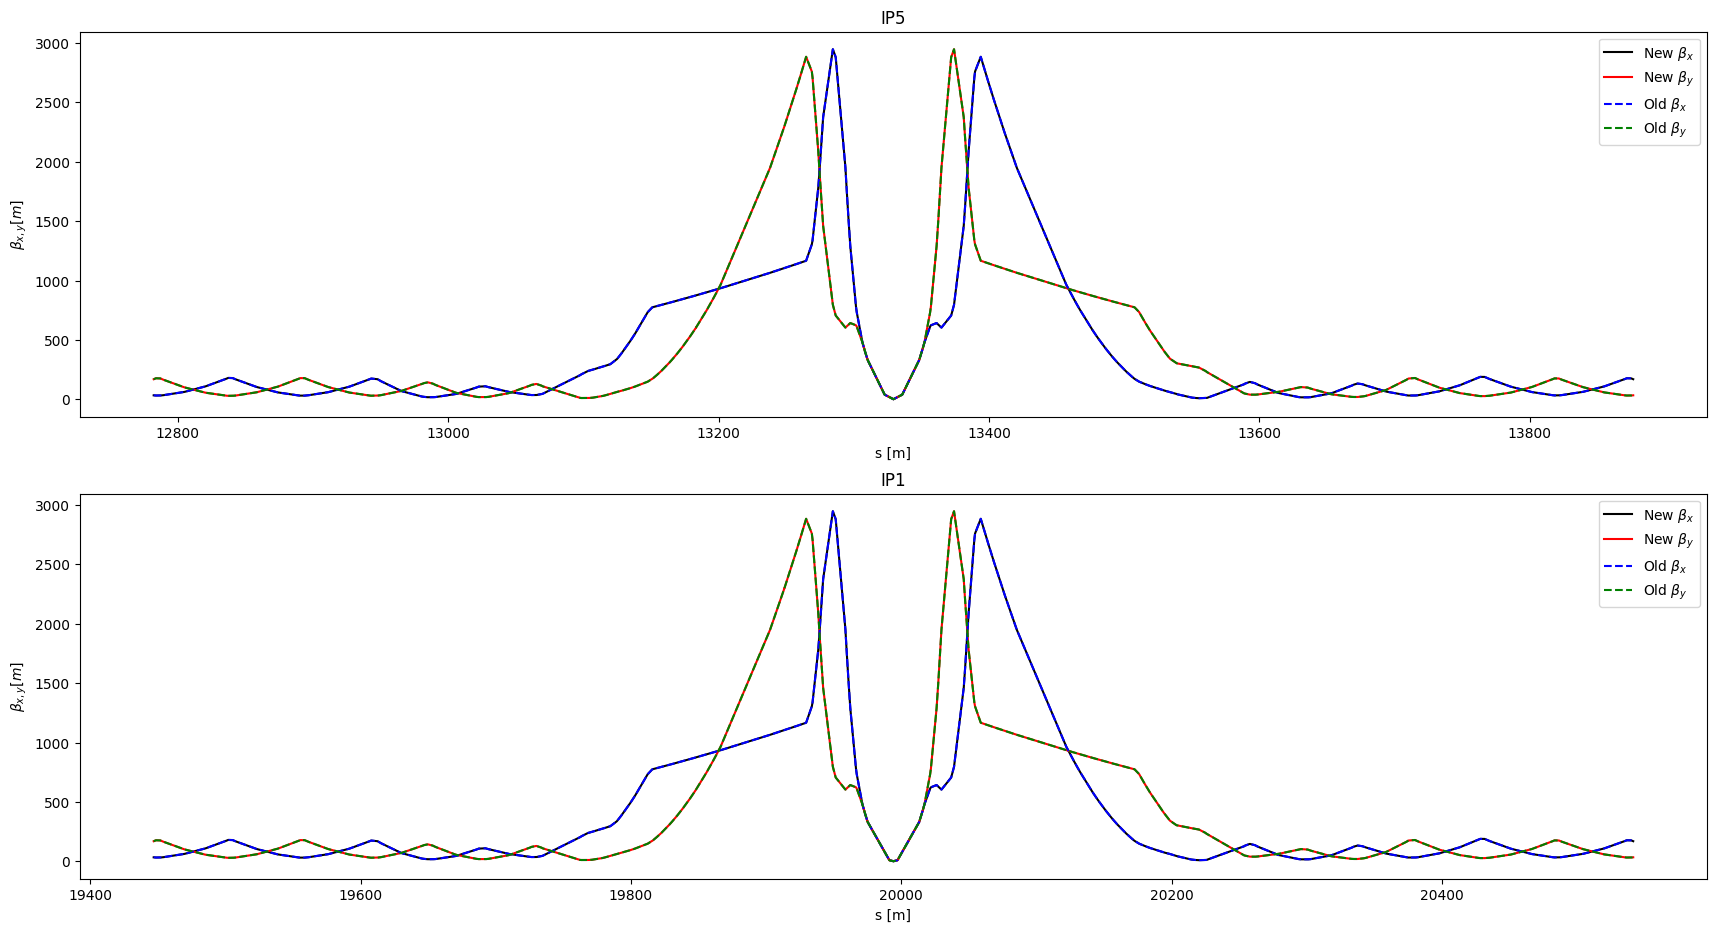

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(21, 11))
axs[0].set_title("IP5")
axs[0].plot(tw_ip5_new.s, tw_ip5_new.betx, color="black", label=r"New $\beta_x$")
axs[0].plot(tw_ip5_new.s, tw_ip5_new.bety, color="red", label=r"New $\beta_y$")
axs[0].plot(tw_ip5.s, tw_ip5.betx, ls="--", color="blue", label=r"Old $\beta_x$")
axs[0].plot(tw_ip5.s, tw_ip5.bety, ls="--", color="green", label=r"Old $\beta_y$")

axs[0].set_xlabel("s [m]")
axs[0].set_ylabel(r"$\beta_{x,y} [m]$")
axs[0].legend()

axs[1].set_title("IP1")
axs[1].plot(tw_ip1_new.s, tw_ip1_new.betx, color="black", label=r"New $\beta_x$")
axs[1].plot(tw_ip1_new.s, tw_ip1_new.bety, color="red", label=r"New $\beta_y$")
axs[1].plot(tw_ip1.s, tw_ip1.betx, ls="--", color="blue", label=r"Old $\beta_x$")
axs[1].plot(tw_ip1.s, tw_ip1.bety, ls="--", color="green", label=r"Old $\beta_y$")

axs[1].set_xlabel("s [m]")
axs[1].set_ylabel(r"$\beta_{x,y} [m]$")
axs[1].legend()


plt.show()

Let's try to change $\beta^\star$, without changing the triplet strengths (match_on_triplet = 0)

In [36]:
betx0_ip1 = 1.2
bety0_ip1 = 1.2
betx0_ip5 = 1.2
bety0_ip5 = 1.2

betx_ip1 = betx0_ip1
bety_ip1 = bety0_ip1
betx_ip5 = betx0_ip5
bety_ip5 = bety0_ip5

In [37]:
optimizers["ir15"] = rematch_ir15(
    collider,
    betx0_ip5,
    bety0_ip5,
    tw_sq_a45_ip5_a56=tw45_56_xt,
    restore=False,
    ir5q4sym=0,
    ir5q5sym=0,
    ir5q6sym=0,
    solve=True,
    match_on_triplet=0,
)

Matching: model call n. 169       

Could not find point within tolerance.




In [38]:
print(optimizers["ir15"].target_status())
print(optimizers["ir15"].log())

Target status:                    
id state tag tol_met      residue  current_val target_val description                                 
 0 ON          False -1.02773e-08          1.2        1.2 line=lhcb1, ('betx', 'ip5'), val=1.2, to ...
 1 ON           True  2.42186e-11          1.2        1.2 line=lhcb1, ('bety', 'ip5'), val=1.2, to ...
 2 ON           True  4.58996e-11  4.58996e-11          0 line=lhcb1, ('alfx', 'ip5'), val=0, tol= ...
 3 ON           True -7.07036e-12 -7.07036e-12          0 line=lhcb1, ('alfy', 'ip5'), val=0, tol= ...
 4 ON          False -3.17473e-10 -3.17473e-10          0 line=lhcb1, ('dx', 'ip5'), val=0, tol=1e ...
 5 ON          False  7.23017e-10  7.23017e-10          0 line=lhcb1, ('dpx', 'ip5'), val=0, tol=1 ...
 6 ON          False -1.14584e-09          1.2        1.2 line=lhcb2, ('betx', 'ip5'), val=1.2, to ...
 7 ON          False  3.43058e-09          1.2        1.2 line=lhcb2, ('bety', 'ip5'), val=1.2, to ...
 8 ON          False  7.10651e-10  7.1

In [41]:
optimizers["ir15"] = rematch_ir15(
    collider,
    betx0_ip5,
    bety0_ip5,
    tw_sq_a45_ip5_a56=tw45_56_xt,
    restore=False,
    ir5q4sym=0,
    ir5q5sym=0,
    ir5q6sym=0,
    solve=True,
    match_on_triplet=0,
)

Matching: model call n. 42       



In [42]:
print(optimizers["ir15"].target_status())
print(optimizers["ir15"].log())

Target status:                   
id state tag tol_met      residue  current_val target_val description                                 
 0 ON           True  7.54952e-15          1.2        1.2 line=lhcb1, ('betx', 'ip5'), val=1.2, to ...
 1 ON           True  3.77476e-15          1.2        1.2 line=lhcb1, ('bety', 'ip5'), val=1.2, to ...
 2 ON           True -1.57308e-14 -1.57308e-14          0 line=lhcb1, ('alfx', 'ip5'), val=0, tol= ...
 3 ON           True  2.49729e-14  2.49729e-14          0 line=lhcb1, ('alfy', 'ip5'), val=0, tol= ...
 4 ON           True -1.99991e-17 -1.99991e-17          0 line=lhcb1, ('dx', 'ip5'), val=0, tol=1e ...
 5 ON           True -1.36798e-17 -1.36798e-17          0 line=lhcb1, ('dpx', 'ip5'), val=0, tol=1 ...
 6 ON           True  7.10543e-15          1.2        1.2 line=lhcb2, ('betx', 'ip5'), val=1.2, to ...
 7 ON           True -2.64233e-14          1.2        1.2 line=lhcb2, ('bety', 'ip5'), val=1.2, to ...
 8 ON           True  1.11343e-14  1.11

In [43]:
tw81_45_new2 = lm.get_arc_periodic_solution(collider, arc_name=["81", "45"])

beta0 = tw81_45_new2["lhcb1"]["45"].get_twiss_init("s.ds.l5.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip5_new = collider.lhcb1.twiss(
    start="s.ds.l5.b1", end="e.ds.r5.b1", init=beta0
)


beta0 = tw81_45_new2["lhcb1"]["81"].get_twiss_init("s.ds.l1.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip1_new = collider.lhcb1.cycle("ip3").twiss(
    start="s.ds.l1.b1", end="e.ds.r1.b1", init=beta0
)


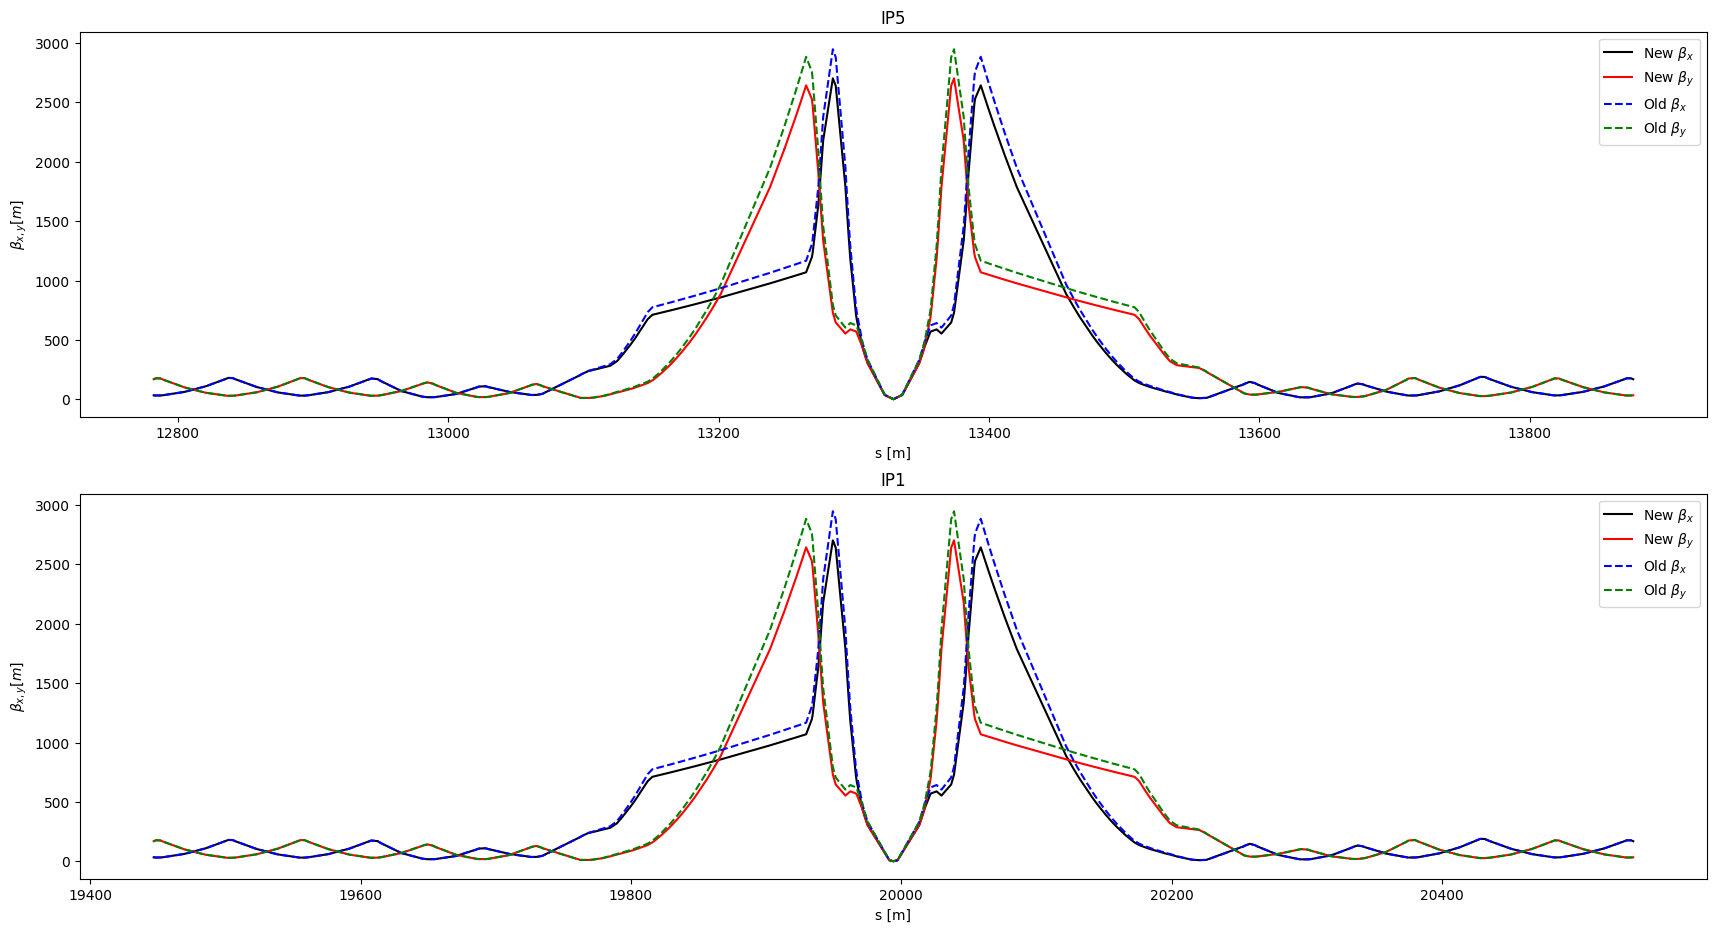

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(21, 11))
axs[0].set_title("IP5")
axs[0].plot(tw_ip5_new.s, tw_ip5_new.betx, color="black", label=r"New $\beta_x$")
axs[0].plot(tw_ip5_new.s, tw_ip5_new.bety, color="red", label=r"New $\beta_y$")
axs[0].plot(tw_ip5.s, tw_ip5.betx, ls="--", color="blue", label=r"Old $\beta_x$")
axs[0].plot(tw_ip5.s, tw_ip5.bety, ls="--", color="green", label=r"Old $\beta_y$")

axs[0].set_xlabel("s [m]")
axs[0].set_ylabel(r"$\beta_{x,y} [m]$")
axs[0].legend()

axs[1].set_title("IP1")
axs[1].plot(tw_ip1_new.s, tw_ip1_new.betx, color="black", label=r"New $\beta_x$")
axs[1].plot(tw_ip1_new.s, tw_ip1_new.bety, color="red", label=r"New $\beta_y$")
axs[1].plot(tw_ip1.s, tw_ip1.betx, ls="--", color="blue", label=r"Old $\beta_x$")
axs[1].plot(tw_ip1.s, tw_ip1.bety, ls="--", color="green", label=r"Old $\beta_y$")

axs[1].set_xlabel("s [m]")
axs[1].set_ylabel(r"$\beta_{x,y} [m]$")
axs[1].legend()


plt.show()